# CITE-seq scSimple Analysis

Using George's dataset, perform differential expression of some marker genes.

In [34]:
import pandas as pd
import numpy as np
import scanpy.api as sc
import imp
import matplotlib as mpl
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from skbio.stats.composition import clr

In [35]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import sc_estimator

In [36]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/'

### Read the mRNA data

In [37]:
adata_rna = sc.read_10x_h5(data_path + 'filtered_gene_bc_matrices_h5.h5', 'hg19')
adata_rna.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Read the ADT data

In [38]:
data_adt = pd.read_csv(data_path + 'final.result.csv', index_col=0).T
data_adt['barcode'] = data_adt.index.tolist()

In [39]:
cd14_counts = data_adt.CD14_M5E2.values
cd4_counts = data_adt['CD4_RPA-T4'].values
cd19_counts = data_adt['CD19_HIB19'].values

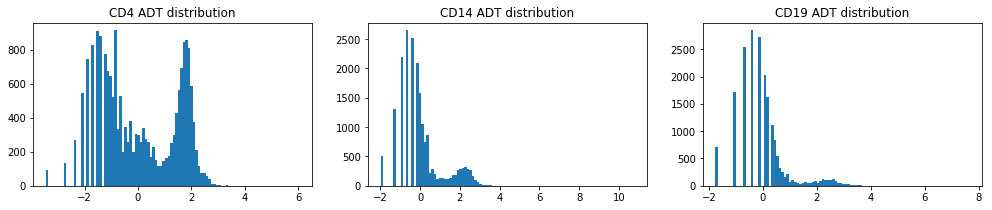

In [40]:
plt.figure(figsize=(17, 3));
plt.subplot(1, 3, 1);
plt.title('CD4 ADT distribution')
plt.hist(clr(cd4_counts+1), bins=100);
plt.subplot(1, 3, 2);
plt.title('CD14 ADT distribution')
plt.hist(clr(cd14_counts+1), bins=100);
plt.subplot(1, 3, 3);
plt.title('CD19 ADT distribution')
plt.hist(clr(cd19_counts+1), bins=100);

In [41]:
cd14_positive_barcodes = data_adt.iloc[clr(cd14_counts+1) > 1, :].index.tolist()
cd4_positive_barcodes = data_adt.iloc[clr(cd4_counts+1) > 1, :].index.tolist()
cd19_positive_barcodes = data_adt.iloc[clr(cd19_counts+1) > 1.3, :].index.tolist()
print('Cut off at 1 after CLR for CD14, CD4 and 1.3 for CD19')

Cut off at 1 after CLR for CD14, CD4 and 1.3 for CD19


### Label some cell types in mRNA using the protein information

In [42]:
def cell_type(bc):
    if bc.split('-')[0] in cd14_positive_barcodes:
        return 'cd14_pos'
    elif bc.split('-')[0] in cd4_positive_barcodes:
        return 'cd4_pos'
    elif bc.split('-')[0] in cd19_positive_barcodes:
        return 'cd19_pos'
    else:
        return 'unknown'

In [43]:
adata_rna.obs['cell_type'] = [cell_type(bc) for bc in adata_rna.obs.index.tolist()]

### Create a scSimple estimator

In [44]:
imp.reload(sc_estimator)

<module 'sc_estimator' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py'>

In [45]:
estimator = sc_estimator.SingleCellEstimator(adata_rna, group_label='cell_type')

### CD14 mRNA expression between CD14+ cells and CD4+ cells

In [46]:
estimator.compute_1d_params('CD14', group='cd14_pos', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)
estimator.compute_1d_params('CD14', group='cd4_pos', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)

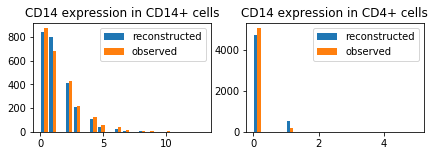

In [47]:
plt.figure(figsize=(7, 2))
plt.subplot(1, 2, 1)
plt.title('CD14 expression in CD14+ cells')
plt.hist(
    [estimator.generate_reconstructed_obs('CD14', group='cd14_pos'),
    adata_rna[adata_rna.obs.cell_type == 'cd14_pos', :][:, 'CD14'].X], bins=20);
plt.legend(['reconstructed', 'observed'])
plt.subplot(1, 2, 2)
plt.title('CD14 expression in CD4+ cells')
plt.hist(
    [estimator.generate_reconstructed_obs('CD14', group='cd4_pos'),
    adata_rna[adata_rna.obs.cell_type == 'cd4_pos', :][:, 'CD14'].X], bins=20);
plt.legend(['reconstructed', 'observed'])

In [50]:
estimator.differential_expression('CD14', groups=('cd4_pos', 'cd14_pos'))
estimator.diff_exp

{'CD14': {('cd4_pos', 'cd14_pos'): (-169.99470512533273,
   2633.918239936554,
   0.0)}}

### CD4 mRNA expression between CD14+ cells and CD4+ cells

Ironially CD14+ cells have more CD4 mRNA than CD4+ cells

In [51]:
estimator.compute_1d_params('CD4', group='cd14_pos', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)
estimator.compute_1d_params('CD4', group='cd4_pos', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)

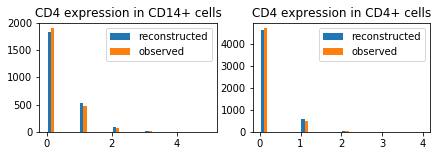

In [52]:
plt.figure(figsize=(7, 2))
plt.subplot(1, 2, 1)
plt.title('CD4 expression in CD14+ cells')
plt.hist(
    [estimator.generate_reconstructed_obs('CD4', group='cd14_pos'),
    adata_rna[adata_rna.obs.cell_type == 'cd14_pos', :][:, 'CD4'].X], bins=20);
plt.legend(['reconstructed', 'observed'])
plt.subplot(1, 2, 2)
plt.title('CD4 expression in CD4+ cells')
plt.hist(
    [estimator.generate_reconstructed_obs('CD4', group='cd4_pos'),
    adata_rna[adata_rna.obs.cell_type == 'cd4_pos', :][:, 'CD4'].X], bins=20);
plt.legend(['reconstructed', 'observed'])

In [53]:
estimator.differential_expression('CD4', groups=('cd4_pos', 'cd14_pos'))
estimator.diff_exp

{'CD14': {('cd4_pos', 'cd14_pos'): (-169.99470512533273,
   2633.918239936554,
   0.0)},
 'CD4': {('cd4_pos', 'cd14_pos'): (-48.98535753222468,
   3228.0614699702596,
   0.0)}}

### CD3 mRNA expression in CD4+ vs CD14+ cells

In [70]:
estimator.compute_1d_params('CD3D', group='cd14_pos', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)
estimator.compute_1d_params('CD3D', group='cd4_pos', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)

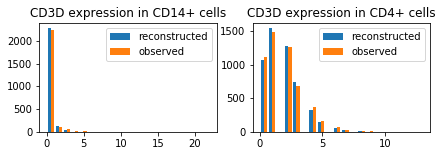

In [71]:
plt.figure(figsize=(7, 2))
plt.subplot(1, 2, 1)
plt.title('CD3D expression in CD14+ cells')
plt.hist(
    [estimator.generate_reconstructed_obs('CD3D', group='cd14_pos'),
    adata_rna[adata_rna.obs.cell_type == 'cd14_pos', :][:, 'CD3D'].X], bins=20);
plt.legend(['reconstructed', 'observed'])
plt.subplot(1, 2, 2)
plt.title('CD3D expression in CD4+ cells')
plt.hist(
    [estimator.generate_reconstructed_obs('CD3D', group='cd4_pos'),
    adata_rna[adata_rna.obs.cell_type == 'cd4_pos', :][:, 'CD3D'].X], bins=20);
plt.legend(['reconstructed', 'observed'])

In [73]:
estimator.differential_expression('CD3D', groups=('cd4_pos', 'cd14_pos'))
estimator.diff_exp['CD3D']

{('cd4_pos', 'cd14_pos'): (97.9517398928843, 3126.165503870036, 0.0)}

### CD19 expression in CD19+ cells vs CD14+ cells

In [56]:
estimator.compute_1d_params('CD19', group='cd14_pos', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)
estimator.compute_1d_params('CD19', group='cd19_pos', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)

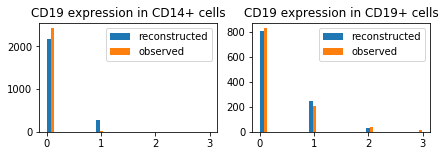

In [61]:
plt.figure(figsize=(7, 2))
plt.subplot(1, 2, 1)
plt.title('CD19 expression in CD14+ cells')
plt.hist(
    [estimator.generate_reconstructed_obs('CD19', group='cd14_pos'),
    adata_rna[adata_rna.obs.cell_type == 'cd14_pos', :][:, 'CD19'].X], bins=20);
plt.legend(['reconstructed', 'observed'])
plt.subplot(1, 2, 2)
plt.title('CD19 expression in CD19+ cells')
plt.hist(
    [estimator.generate_reconstructed_obs('CD19', group='cd19_pos'),
    adata_rna[adata_rna.obs.cell_type == 'cd19_pos', :][:, 'CD19'].X], bins=20);
plt.legend(['reconstructed', 'observed'])

In [63]:
estimator.differential_expression('CD19', groups=('cd14_pos', 'cd19_pos'))
estimator.diff_exp['CD19']

{('cd14_pos', 'cd19_pos'): (-45.506354121569714,
  1183.848108791767,
  3.041780828345379e-262)}